In [1]:
import os
import cv2

import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

import albumentations as alb

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
images.as_numpy_iterator().next()

b'data\\images\\1bc60f85-bb2c-11ee-a411-2cf05dff1d7f.jpg'

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [6]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[100,  94,  96],
        [ 98,  92,  94],
        [102,  93,  94],
        ...,
        [105,  94,  98],
        [105,  94,  98],
        [103,  92,  96]],

       [[102,  96,  98],
        [ 99,  93,  95],
        [103,  94,  95],
        ...,
        [105,  94,  98],
        [106,  95,  99],
        [105,  94,  98]],

       [[105,  96,  99],
        [101,  92,  95],
        [104,  94,  95],
        ...,
        [103,  92,  98],
        [104,  93,  99],
        [102,  91,  97]],

       ...,

       [[ 22,  22,  22],
        [ 23,  23,  23],
        [ 24,  24,  24],
        ...,
        [ 34,  28,  30],
        [ 34,  28,  32],
        [ 33,  27,  31]],

       [[ 23,  21,  22],
        [ 23,  21,  22],
        [ 25,  23,  24],
        ...,
        [ 34,  30,  31],
        [ 34,  29,  33],
        [ 33,  28,  32]],

       [[ 24,  22,  23],
        [ 24,  22,  23],
        [ 26,  24,  25],
        ...,
        [ 31,  27,  28],
        [ 32,  27,  31],
        [ 34,  29,  33]]

In [7]:
# Chia các tensor theo lô batch(batch_size), sau đó chuyển nó thành một iter
image_generator = images.batch(5).as_numpy_iterator()

In [8]:
# Sử dụng iter để lấy ra từng lô tensor và plot
plot_images = image_generator.next()

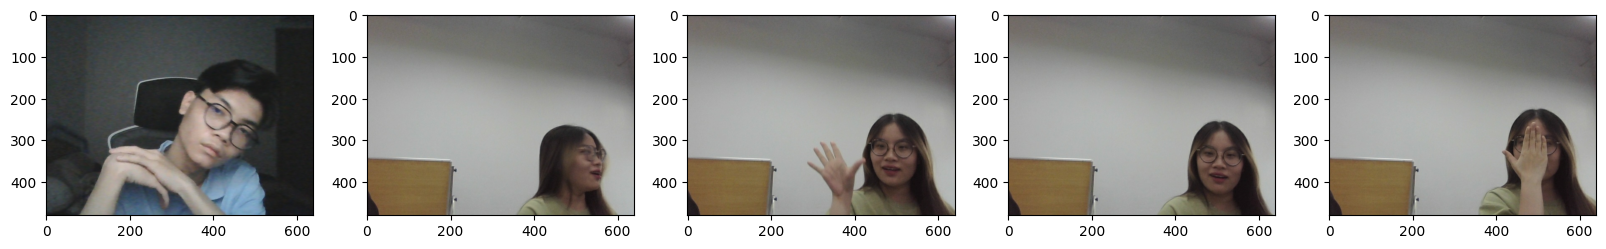

In [9]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [10]:
augmentor = alb.Compose([
                         # Random Crop dùng để cắt hình ảnh theo width và height
                         alb.RandomCrop(width=450, height=450),
                         # Random Horizontal Flip sẽ thay đổi hình ảnh theo chiều ngang
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [12]:
img = cv2.imread(os.path.join('data', 'train', 'images', 'ed3a553b-b3a1-11ee-987a-2cf05dff1d7f.jpg'))
img.shape

(480, 640, 3)

In [14]:
with open(os.path.join('data', 'train', 'labels', 'ed3a553b-b3a1-11ee-987a-2cf05dff1d7f.json'), 'r') as f:
    label = json.load(f)
label

{'version': '5.4.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[172.13903743315512, 159.7860962566845],
    [327.75401069518716, 339.99999999999994]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\ed3a553b-b3a1-11ee-987a-2cf05dff1d7f.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAV

In [15]:
# Làm phẳng lại ma trận
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.2689672459893049,
 0.33288770053475936,
 0.5121156417112299,
 0.7083333333333333]

In [17]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[ 92, 100, 100],
         [ 92, 100, 100],
         [ 92, 100, 100],
         ...,
         [104, 109, 108],
         [103, 108, 107],
         [103, 109, 108]],
 
        [[ 91, 102, 100],
         [ 91, 102, 100],
         [ 91, 102, 100],
         ...,
         [106, 110, 111],
         [105, 110, 113],
         [101, 110, 113]],
 
        [[ 90, 103, 101],
         [ 90, 103, 101],
         [ 90, 103, 101],
         ...,
         [107, 112, 115],
         [103, 112, 116],
         [101, 113, 117]],
 
        ...,
 
        [[ 62,  61,  63],
         [ 63,  62,  64],
         [ 63,  62,  64],
         ...,
         [ 26,  21,  22],
         [ 24,  22,  22],
         [ 24,  22,  22]],
 
        [[ 60,  64,  65],
         [ 59,  64,  65],
         [ 58,  62,  63],
         ...,
         [ 26,  21,  22],
         [ 24,  22,  22],
         [ 24,  22,  22]],
 
        [[ 54,  64,  64],
         [ 52,  64,  64],
         [ 53,  63,  63],
         ...,
         [ 26,  21,

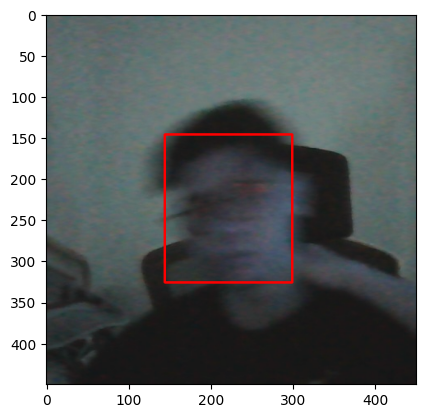

In [18]:
# Vẽ một ô hình chữ nhật trong hình theo tọa độ của bboxes
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [20]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        #  Coordiantes of bounding box for images are not have annotations
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

        # Check whether label exists or not
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.5572359625668449, 0.6336898395721924, 0.44192847593582896, 0.43315508021390375, 'face'].


In [21]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)))
train_images = train_images.map(lambda x: x/255)

In [23]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)))
test_images = test_images.map(lambda x: x/255)

In [24]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)))
val_images = val_images.map(lambda x: x/255)

In [5]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [26]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [28]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(10000)
train = train.batch(8)
train = train.prefetch(4)

In [31]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3000)
test = test.batch(8)
test = test.prefetch(4)

In [32]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(3000)
val = val.batch(8)
val = val.prefetch(4)

In [33]:
data_samples = train.as_numpy_iterator()

In [36]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


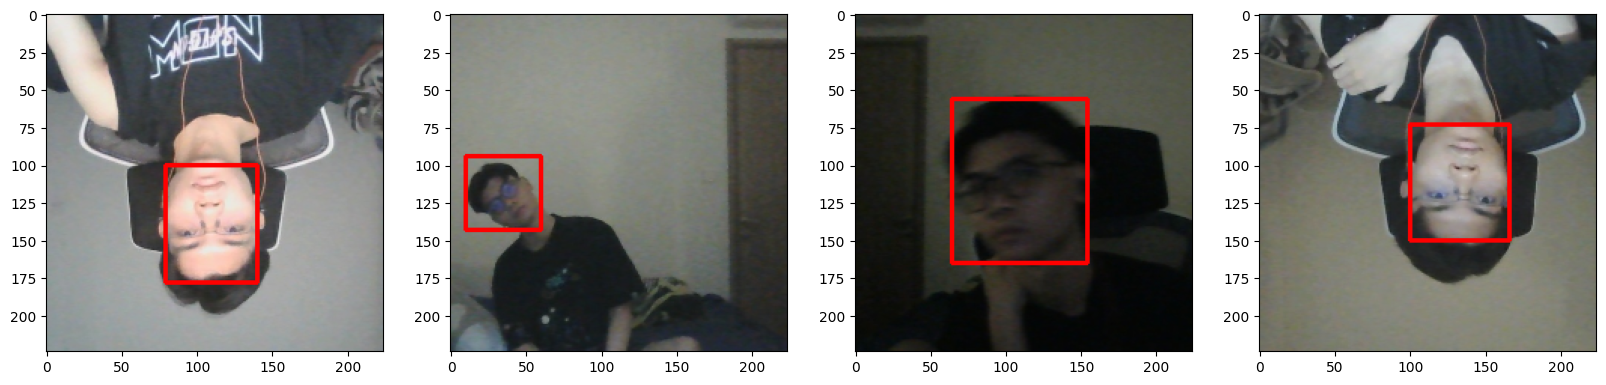

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image = np.array(sample_image)
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [224,224]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [224,224]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [40]:
#!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)


In [6]:
import gc
import cv2
import glob
import keras_vggface

print(keras_vggface.__version__)

0.6


In [18]:
from keras_vggface.vggface import VGGFace

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D

In [9]:
vggface = VGGFace(model='resnet50', include_top=False)

In [10]:
vggface.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, None, None,   9408        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, None, None,   256        ['conv1/7x7_s2[0][0]']           
 ation)                         64)                                                

In [11]:
def build_model():
    input_layer = Input(shape=(224, 224, 3))
    print(input_layer)
    vggface = VGGFace(model='resnet50', include_top=False)(input_layer)


    # Classification Model
    f1 = GlobalMaxPooling2D()(vggface)
    class1 = Dense(2048, activation='relu')(f1) # lấy dương còn âm bỏ đi
    class2 = Dense(1, activation='sigmoid')(class1) # chuyển giá trị về trong khoảng 0 - 1

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vggface)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [12]:
facetracker = build_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [13]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vggface_resnet50 (Functional)  (None, None, None,   23561152    ['input_2[0][0]']                
                                2048)                                                             
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 2048)        0           ['vggface_resnet50[0][0]']       
 xPooling2D)                                                                                  

In [49]:
X, y = train.as_numpy_iterator().next()

In [81]:
X.shape

(8, 224, 224, 3)

In [50]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 15s 15s/step


In [51]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [19]:
from tensorflow.keras.optimizers import legacy

In [53]:
opt = legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [20]:
# Define localization loss and classification loss
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [55]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [56]:
localization_loss(y[1], coords).numpy()

4.5022774

In [57]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1181138>

In [58]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.5022774>

In [15]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [16]:
model = FaceTracker(facetracker)

In [61]:
model.compile(opt, classloss, regressloss)

In [62]:
logdir='logs'

In [63]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
1013/1013 [==============================] - 147s 126ms/step - total_loss: 0.8288 - class_loss: 0.2068 - regress_loss: 0.7254 - val_total_loss: 0.0426 - val_class_loss: 0.0011 - val_regress_loss: 0.0420
Epoch 2/15
1013/1013 [==============================] - 133s 125ms/step - total_loss: 0.1000 - class_loss: 0.0316 - regress_loss: 0.0842 - val_total_loss: 0.0162 - val_class_loss: 2.8170e-04 - val_regress_loss: 0.0160
Epoch 3/15
1013/1013 [==============================] - 134s 125ms/step - total_loss: 0.0694 - class_loss: 0.0221 - regress_loss: 0.0584 - val_total_loss: 0.0150 - val_class_loss: 8.3945e-05 - val_regress_loss: 0.0150
Epoch 4/15
1013/1013 [==============================] - 134s 125ms/step - total_loss: 0.0606 - class_loss: 0.0230 - regress_loss: 0.0491 - val_total_loss: 0.0352 - val_class_loss: 0.0163 - val_regress_loss: 0.0270
Epoch 5/15
1013/1013 [==============================] - 133s 125ms/step - total_loss: 0.0390 - class_loss: 0.0132 - regress_loss: 0.0324

In [65]:
hist.history

{'total_loss': [0.05626946687698364,
  0.04391125962138176,
  0.021623045206069946,
  0.009286528453230858,
  0.0061037116684019566,
  0.0044802348129451275,
  0.002736395224928856,
  0.005953003186732531,
  0.005961515475064516,
  0.00416587432846427,
  0.0021146186627447605,
  0.0010519693605601788,
  0.0018999549793079495,
  0.0014464949490502477,
  0.0012436576653271914],
 'class_loss': [0.00868989434093237,
  0.031282201409339905,
  0.0009002385777421296,
  0.0028242128901183605,
  0.0005147095071151853,
  0.0008748768595978618,
  0.00012184186925878748,
  1.8775506305246381e-06,
  9.298414624936413e-06,
  0.00014541592099703848,
  3.317110531497747e-05,
  7.74860836827429e-07,
  1.8179468952439493e-06,
  0.0015237126499414444,
  1.7077090888051316e-05],
 'regress_loss': [0.05192451924085617,
  0.028270158916711807,
  0.02117292582988739,
  0.007874421775341034,
  0.005846356973052025,
  0.004042796324938536,
  0.00267547438852489,
  0.005952064413577318,
  0.005956866312772036,
 

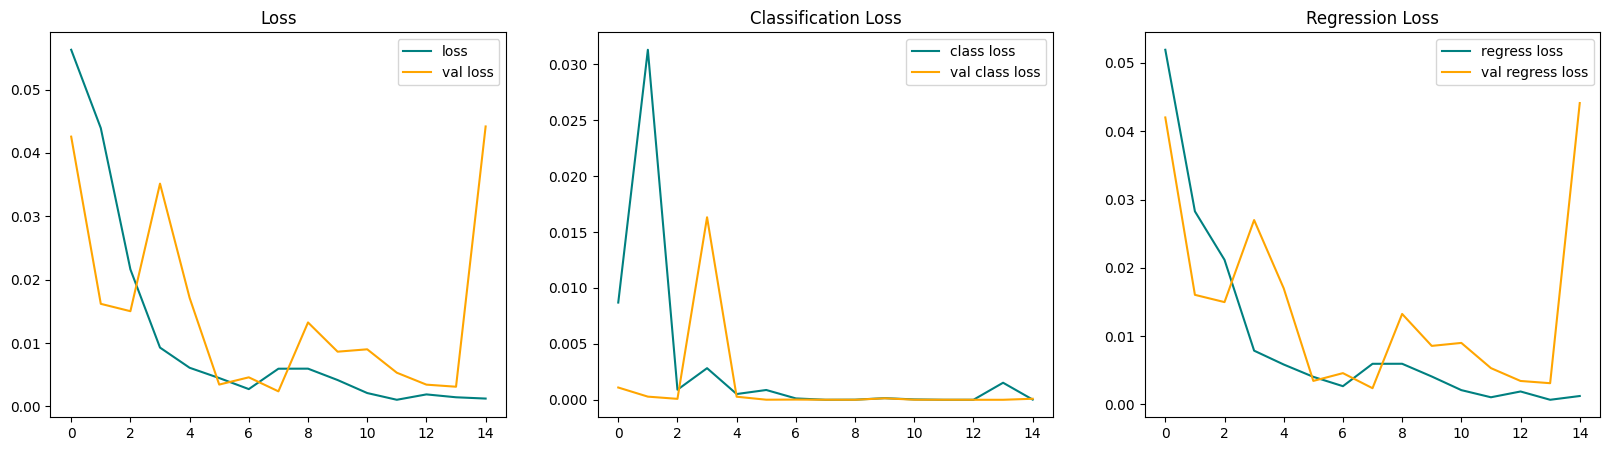

In [66]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [67]:
test_data = test.as_numpy_iterator()

In [68]:
test_sample = test_data.next()

In [69]:
test_sample[0]

array([[[[0.6665793 , 0.6038342 , 0.5410891 ],
         [0.66383076, 0.60500723, 0.53049743],
         [0.6676817 , 0.60885817, 0.53434837],
         ...,
         [0.7744572 , 0.7067572 , 0.6068631 ],
         [0.7843667 , 0.70882326, 0.60782605],
         [0.78039217, 0.70980394, 0.61957264]],

        [[0.65600467, 0.6050243 , 0.5383576 ],
         [0.6746149 , 0.6157914 , 0.5412815 ],
         [0.6646183 , 0.6057948 , 0.531285  ],
         ...,
         [0.7763305 , 0.7066537 , 0.61281633],
         [0.7793585 , 0.7106786 , 0.6127444 ],
         [0.7774333 , 0.71276283, 0.621604  ]],

        [[0.67559487, 0.6246145 , 0.5579478 ],
         [0.67058825, 0.61960787, 0.54509807],
         [0.67263657, 0.61381304, 0.53930324],
         ...,
         [0.77459735, 0.71185225, 0.6216562 ],
         [0.78042716, 0.71768206, 0.627486  ],
         [0.7824405 , 0.7196954 , 0.6294993 ]],

        ...,

        [[0.17675084, 0.08226612, 0.02944756],
         [0.2422996 , 0.0677183 , 0.02878286]

In [70]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


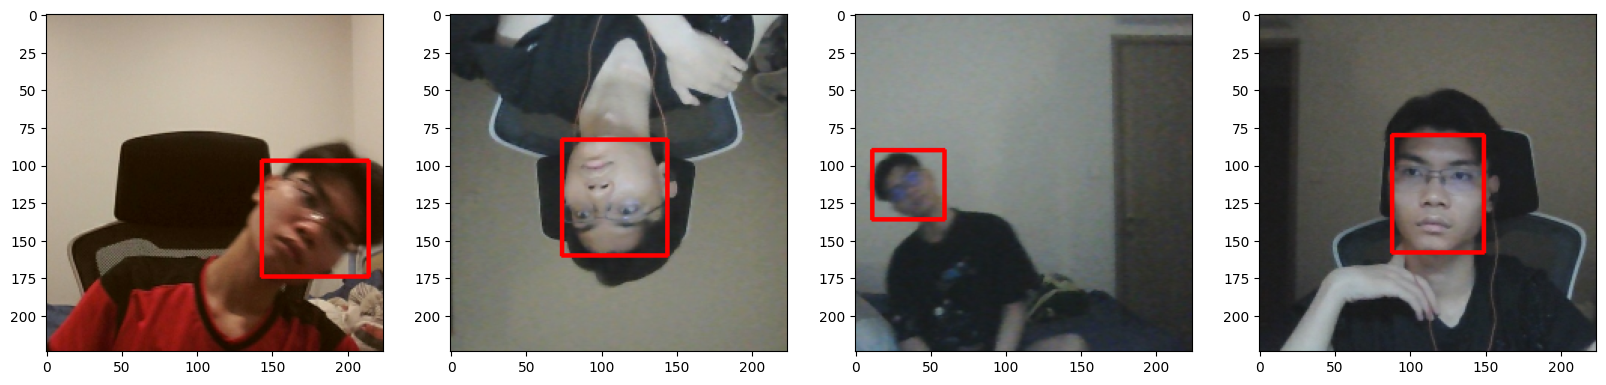

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    sample_image = np.array(sample_image)
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [224,224]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [224,224]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [21]:
from tensorflow.keras.models import load_model

In [75]:
facetracker.save('vggface_weights.h5')

In [22]:
facetracker = load_model('vggface_weights.h5')

In [23]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (224,224))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.9: 
        # Tạo khung khoanh vùng nhận diện khuôn mặt
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        
        # Khung hiển thị class
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [70,0])), 
                            (255,0,0), -1)
        
        # Cài đặt vị trí đặt tên class
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()# Giải phóng window
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


In [86]:
resized = tf.image.resize(rgb, (224,224))
np.expand_dims(resized/255,0).shape

(1, 224, 224, 3)

In [91]:
cap.release()# Giải phóng window
cv2.destroyAllWindows()